In [2]:
import sys
sys.path.append('../build')

import ase.io
import numpy as np
import matplotlib.pyplot as plt

import rascal
from rascal.representations import PairDistances
from rascal.models import Kernel

# Testing the calculator on some reference structures

In [3]:
samples = ase.io.read('../reference_data/inputs/methane_dimer_sample.xyz', ':')
energies = np.array([cc.info["energy"] for cc in samples])

In [644]:
energies.shape

(2418,)

In [642]:
samples[0].info

{'energy': -0.00998655,
 'ediff_cc': -0.00109638,
 'cutoff': -1.0,
 'nneightol': 1.2}

In [3]:
samples[0].get_distance(0, 5)

4.703209312880156

In [4]:
no_atoms = len(samples[0].get_positions())

In [5]:
no_pair_distances = no_atoms*(no_atoms-1)

First we need to set the unit cells. These are isolated molecular systems, so we just need to "pad" the unit cell enough that periodic images don't show up within the cutoff we've chosen.

In [4]:
for dim in samples:
    cell_extents = (np.max(dim.get_positions(), axis=0)
                    - np.min(dim.get_positions(), axis=0)
                    + np.array([30, 30, 30]))
    dim.set_cell(cell_extents)
    dim.set_positions(dim.get_positions() + cell_extents / 2.)

Now initialize the calculator with some fairly standard params.

In [5]:
pd = PairDistances(interaction_cutoff=12.0, cutoff_smooth_width=0.5, n_species=2)

In [6]:
rep = pd.transform(samples)

In [7]:
X = rep.get_features(pd)

In [10]:
X.shape

(217620, 3)

In [11]:
X[:90].shape

(90, 3)

This is the list of pair distances for the first molecule (90 pairs in total, since each pair comes up twice).  The C-C pair, with the distance we computed above, shows up as the only entry in the final column, which tells us that's the C-C column.  The other two columns are H-H (you can see the repeated intramolecular distance of 1.77 Å) and C-H (with the 1.08 Å C-H bond length again visible).

In [12]:
X[:90]

array([[0.        , 1.08814377, 0.        ],
       [0.        , 1.08800326, 0.        ],
       [0.        , 1.08800193, 0.        ],
       [0.        , 1.08811616, 0.        ],
       [0.        , 0.        , 4.70320931],
       [0.        , 5.43436821, 0.        ],
       [0.        , 4.06440486, 0.        ],
       [0.        , 4.28393093, 0.        ],
       [0.        , 5.36770046, 0.        ],
       [0.        , 1.08814377, 0.        ],
       [1.77649564, 0.        , 0.        ],
       [1.77651711, 0.        , 0.        ],
       [1.77691627, 0.        , 0.        ],
       [0.        , 3.70468279, 0.        ],
       [4.37772004, 0.        , 0.        ],
       [3.11946921, 0.        , 0.        ],
       [3.28993702, 0.        , 0.        ],
       [4.46261608, 0.        , 0.        ],
       [0.        , 1.08800326, 0.        ],
       [1.77649564, 0.        , 0.        ],
       [1.77694096, 0.        , 0.        ],
       [1.77697233, 0.        , 0.        ],
       [0.

In [141]:
CC_dist = X.T[2][X.T[2] != 0][::2]

In [148]:
CH_dist = X.T[1][X.T[1] != 0]
CH_dist.sort()
CH_dist = CH_dist[::2]

In [150]:
HH_dist = X.T[0][X.T[0] != 0]
HH_dist.sort()
HH_dist = HH_dist[::2]

In [13]:
k = Kernel(pd, name="Gaussian", target_type="Structure",theta=1)

In [14]:
kernel_matrix=k.__call__(rep, rep)
kernel_matrix

array([[1742.13140291, 1238.33947898, 1736.92358128, ..., 1716.07959537,
        1702.36703626, 1707.82295466],
       [1238.33947898, 1661.02759985, 1250.44516206, ..., 1194.10874911,
        1165.15620152, 1169.53486087],
       [1736.92358128, 1250.44516206, 1732.92764807, ..., 1690.28782541,
        1676.61847649, 1682.15158254],
       ...,
       [1716.07959537, 1194.10874911, 1690.28782541, ..., 2276.30819665,
        2245.96027935, 2247.86144303],
       [1702.36703626, 1165.15620152, 1676.61847649, ..., 2245.96027935,
        2220.09264427, 2221.15287381],
       [1707.82295466, 1169.53486087, 1682.15158254, ..., 2247.86144303,
        2221.15287381, 2222.64511403]])

In [1272]:
kernel_matrix = kernel_matrix / np.diag(kernel_matrix)

In [1274]:
np.diag(kernel_matrix)

array([1., 1., 1., ..., 1., 1., 1.])

In [1273]:
kernel_matrix

array([[1.        , 0.74552613, 1.00230589, ..., 0.75388719, 0.7668    ,
        0.76837411],
       [0.71081864, 1.        , 0.72157956, ..., 0.52458132, 0.52482323,
        0.52619055],
       [0.99701066, 0.7528142 , 1.        , ..., 0.74255667, 0.75520203,
        0.75682419],
       ...,
       [0.98504601, 0.7188976 , 0.97539434, ..., 1.        , 1.0116516 ,
        1.01134519],
       [0.97717488, 0.70146709, 0.96750633, ..., 0.98666792, 1.        ,
        0.99932862],
       [0.98030662, 0.70410321, 0.97069926, ..., 0.98750312, 1.00047756,
        1.        ]])

In [87]:
np.linalg.cond(kernel_matrix + np.eye(len(kernel_matrix[0])))

4052049.4096545572

In [8]:
def kernel_regression(energies, kernel, sigma):
    "Calculate the weights, alpha, from the kernel regression"
    N = len(energies)
    alpha = np.linalg.lstsq(kernel + np.transpose(kernel).dot(np.linalg.inv(np.eye(N)*sigma**2)).dot(kernel), np.transpose(kernel).dot(np.linalg.inv(np.eye(N)*sigma**2)).dot(np.transpose(energies)))[0]
    return alpha

In [9]:
def new_kernel_regression(energies, kernel, sigma):
    "Calculate the weights, alpha, from the kernel regression"
    N = len(energies)
    alpha = np.linalg.lstsq(kernel + np.eye(N)*sigma**2, np.transpose(energies))[0]
    return alpha

In [10]:
def energy_fit(kernel, alpha):
    "Return the kernel fit of the energies"
    return kernel.dot(alpha)

In [20]:
alpha=kernel_regression(energies, kernel_matrix, 1)

/local/home/local/miniconda3/envs/librascal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [82]:
new_alpha=new_kernel_regression(energies, kernel_matrix, 1)

/local/home/local/miniconda3/envs/librascal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [150]:
fitted_energies = energy_fit(kernel_matrix, alpha)

In [83]:
new_fitted_energies = energy_fit(kernel_matrix, new_alpha)

In [126]:
X.T[2][X.T[2] != 0][::2]

array([4.70320931, 6.78989535, 4.77137582, ..., 3.22152714, 3.33224798,
       3.32486136])

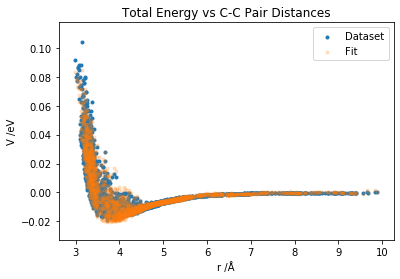

In [195]:
plt.scatter(X.T[2][X.T[2] != 0][::2], energies, marker = ".", label="Dataset")
plt.scatter(X.T[2][X.T[2] != 0][::2], fitted_energies,marker=".", label="Fit", alpha=0.2)
plt.xlabel("r /Å")
plt.ylabel("V /eV")
plt.title("Total Energy vs C-C Pair Distances")
plt.legend()
plt.show()

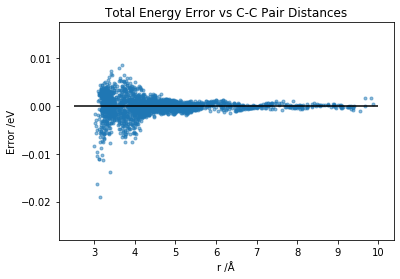

In [196]:
plt.scatter(X.T[2][X.T[2] != 0][::2], fitted_energies-energies,marker=".", alpha=0.5)
plt.hlines(0, 2.5,10)
plt.xlabel("r /Å")
plt.ylabel("Error /eV")
plt.title("Total Energy Error vs C-C Pair Distances")
plt.show()

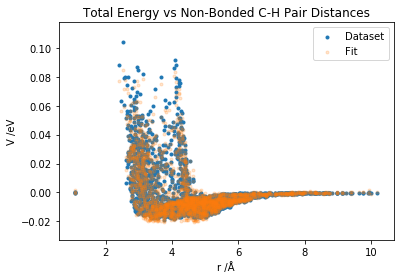

In [375]:
plt.scatter(X.T[1][X.T[1] != 0][4::32], energies, marker = ".", label="Dataset")
plt.scatter(X.T[1][X.T[1] != 0][4::32], fitted_energies,marker=".", label="Fit", alpha=0.2)
plt.xlabel("r /Å")
plt.ylabel("V /eV")
plt.title("Total Energy vs Non-Bonded C-H Pair Distances")
plt.legend()
plt.show()

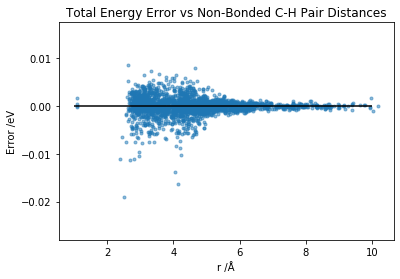

In [200]:
plt.scatter(X.T[1][X.T[1] != 0][4::32], fitted_energies-energies,marker=".", alpha=0.5)
plt.hlines(0, 1,10)
plt.xlabel("r /Å")
plt.ylabel("Error /eV")
plt.title("Total Energy Error vs Non-Bonded C-H Pair Distances")
plt.show()

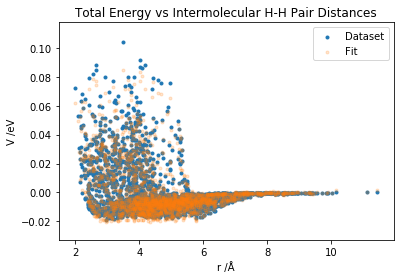

In [203]:
plt.scatter(X.T[0][X.T[0] != 0][3::56], energies, marker = ".", label="Dataset")
plt.scatter(X.T[0][X.T[0] != 0][3::56], fitted_energies,marker=".", label="Fit", alpha=0.2)
plt.xlabel("r /Å")
plt.ylabel("V /eV")
plt.title("Total Energy vs Intermolecular H-H Pair Distances")
plt.legend()
plt.show()

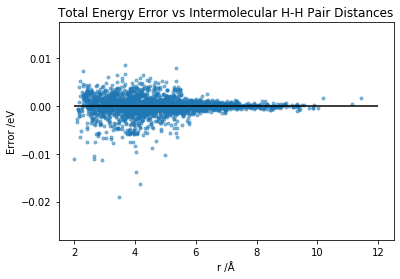

In [204]:
plt.scatter(X.T[0][X.T[0] != 0][3::56], fitted_energies-energies,marker=".", alpha=0.5)
plt.hlines(0, 2,12)
plt.xlabel("r /Å")
plt.ylabel("Error /eV")
plt.title("Total Energy Error vs Intermolecular H-H Pair Distances")
plt.show()

In [205]:
np.sqrt(np.mean((fitted_energies-energies)**2))/2

0.0009942540534184704

### Varying Theta in the kernel

In [64]:
k2 = Kernel(pd, name="Gaussian", target_type="Structure",theta=2)
kernel_matrix2=k2.__call__(rep, rep)
alpha2=kernel_regression(energies, kernel_matrix2, 1)
fitted_energies2 = energy_fit(kernel_matrix2, alpha2)

/local/home/local/miniconda3/envs/librascal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [89]:
np.linalg.matrix_rank(np.transpose(kernel_matrix2).dot(np.linalg.inv(np.eye(len(energies)))).dot(kernel_matrix2))

9

In [90]:
np.linalg.matrix_rank(kernel_matrix2)

33

In [91]:
np.linalg.cond(kernel_matrix2 + np.eye(len(kernel_matrix2[0])))

6201949.682337756

In [65]:
k_half = Kernel(pd, name="Gaussian", target_type="Structure",theta=0.5)
kernel_matrix_half=k_half.__call__(rep, rep)
alpha_half=kernel_regression(energies, kernel_matrix_half, 1)
fitted_energies_half = energy_fit(kernel_matrix_half, alpha_half)

/local/home/local/miniconda3/envs/librascal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [92]:
np.linalg.matrix_rank(np.transpose(kernel_matrix_half).dot(np.linalg.inv(np.eye(len(energies)))).dot(kernel_matrix_half))

52

In [93]:
np.linalg.matrix_rank(kernel_matrix_half)

109

In [94]:
np.linalg.cond(kernel_matrix_half + np.eye(len(kernel_matrix_half[0])))

2938981.206423668

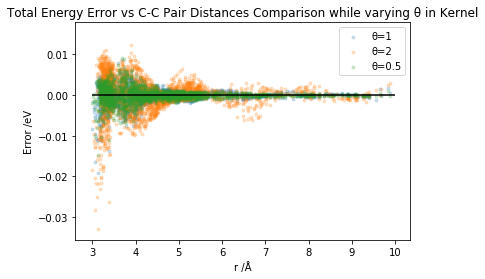

In [206]:
plt.scatter(X.T[2][X.T[2] != 0][::2], fitted_energies-energies,marker=".", alpha=0.2, label="θ=1")
plt.scatter(X.T[2][X.T[2] != 0][::2], fitted_energies2-energies,marker=".", alpha=0.2, label="θ=2")
plt.scatter(X.T[2][X.T[2] != 0][::2], fitted_energies_half-energies,marker=".", alpha=0.2, label="θ=0.5")
plt.hlines(0, 3,10)
plt.xlabel("r /Å")
plt.ylabel("Error /eV")
plt.title("Total Energy Error vs C-C Pair Distances Comparison while varying θ in Kernel")
plt.legend()
plt.show()

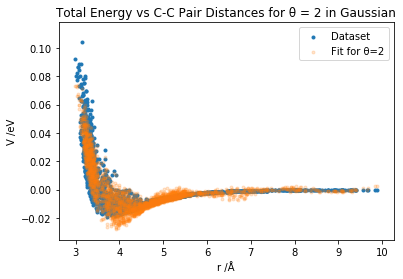

In [207]:
plt.scatter(X.T[2][X.T[2] != 0][::2], energies, marker = ".", label="Dataset")
plt.scatter(X.T[2][X.T[2] != 0][::2], fitted_energies2,marker=".", label="Fit for θ=2", alpha=0.2)
plt.xlabel("r /Å")
plt.ylabel("V /eV")
plt.title("Total Energy vs C-C Pair Distances for θ = 2 in Gaussian")
plt.legend()
plt.show()

In [208]:
np.sqrt(np.mean((fitted_energies2-energies)**2))/2

0.0021199649543712775

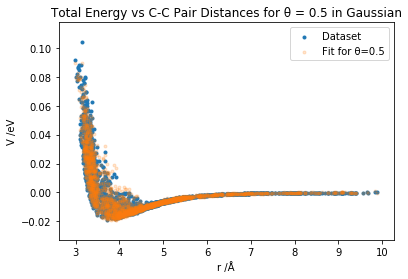

In [209]:
plt.scatter(X.T[2][X.T[2] != 0][::2], energies, marker = ".", label="Dataset")
plt.scatter(X.T[2][X.T[2] != 0][::2], fitted_energies_half,marker=".", label="Fit for θ=0.5", alpha=0.2)
plt.xlabel("r /Å")
plt.ylabel("V /eV")
plt.title("Total Energy vs C-C Pair Distances for θ = 0.5 in Gaussian")
plt.legend()
plt.show()

In [210]:
np.sqrt(np.mean((fitted_energies_half-energies)**2))/2

0.0008492563219710315

In [11]:
k0_8 = Kernel(pd, name="Gaussian", target_type="Structure",theta=0.8)
kernel_matrix0_8 = k0_8.__call__(rep, rep)

In [12]:
k0_8_diags = np.diag(kernel_matrix0_8)

In [14]:
norm_kernel_matrix0_8 = kernel_matrix0_8 / np.sqrt(np.outer(k0_8_diags, k0_8_diags))

In [15]:
kernel_matrix0_8

array([[1584.12668021, 1123.78413041, 1580.41347457, ..., 1500.61195965,
        1480.23426245, 1489.23945315],
       [1123.78413041, 1550.53537393, 1135.68105886, ..., 1079.32788318,
        1044.14871315, 1051.27060107],
       [1580.41347457, 1135.68105886, 1578.4028513 , ..., 1477.7235568 ,
        1457.17748851, 1466.07789152],
       ...,
       [1500.61195965, 1079.32788318, 1477.7235568 , ..., 1998.10073082,
        1964.37889773, 1969.38531302],
       [1480.23426245, 1044.14871315, 1457.17748851, ..., 1964.37889773,
        1937.83495497, 1940.89791956],
       [1489.23945315, 1051.27060107, 1466.07789152, ..., 1969.38531302,
        1940.89791956, 1945.02229676]])

In [16]:
norm_kernel_matrix0_8

array([[1.        , 0.71704614, 0.99946328, ..., 0.84346052, 0.84484513,
        0.84841295],
       [0.71704614, 1.        , 0.72594984, ..., 0.61320243, 0.60236971,
        0.60535675],
       [0.99946328, 0.72594984, 1.        , ..., 0.83210011, 0.83319208,
        0.83673093],
       ...,
       [0.84346052, 0.61320243, 0.83210011, ..., 1.        , 0.99829335,
        0.99898672],
       [0.84484513, 0.60236971, 0.83319208, ..., 0.99829335, 1.        ,
        0.99972835],
       [0.84841295, 0.60535675, 0.83673093, ..., 0.99898672, 0.99972835,
        1.        ]])

### Varying Sigma Hyperparameter

In [67]:
alpha_sigma2=kernel_regression(energies, kernel_matrix, 2)
fitted_energies_sigma2 = energy_fit(kernel_matrix, alpha_sigma2)

/local/home/local/miniconda3/envs/librascal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [68]:
alpha_sigma_half=kernel_regression(energies, kernel_matrix, 0.5)
fitted_energies_sigma_half = energy_fit(kernel_matrix, alpha_sigma_half)

/local/home/local/miniconda3/envs/librascal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


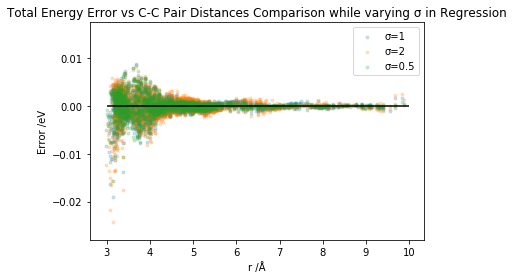

In [211]:
plt.scatter(X.T[2][X.T[2] != 0][::2], fitted_energies-energies,marker=".", alpha=0.2, label="σ=1")
plt.scatter(X.T[2][X.T[2] != 0][::2], fitted_energies_sigma2-energies,marker=".", alpha=0.2, label="σ=2")
plt.scatter(X.T[2][X.T[2] != 0][::2], fitted_energies_sigma_half-energies,marker=".", alpha=0.2, label="σ=0.5")
plt.hlines(0, 3,10)
plt.xlabel("r /Å")
plt.ylabel("Error /eV")
plt.title("Total Energy Error vs C-C Pair Distances Comparison while varying σ in Regression")
plt.legend()
plt.show()

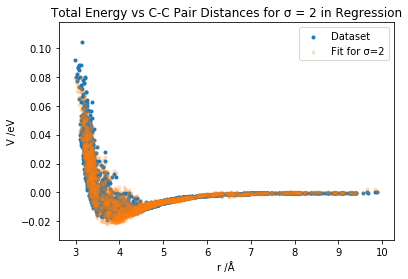

In [212]:
plt.scatter(X.T[2][X.T[2] != 0][::2], energies, marker = ".", label="Dataset")
plt.scatter(X.T[2][X.T[2] != 0][::2], fitted_energies_sigma2,marker=".", label="Fit for σ=2", alpha=0.2)
plt.xlabel("r /Å")
plt.ylabel("V /eV")
plt.title("Total Energy vs C-C Pair Distances for σ = 2 in Regression")
plt.legend()
plt.show()

In [213]:
np.sqrt(np.mean((fitted_energies_sigma2-energies)**2))/2

0.0012230644502889583

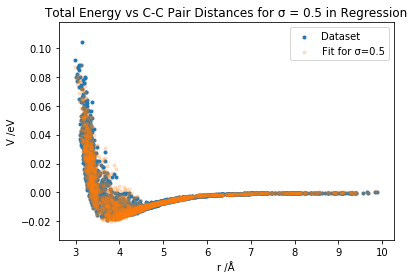

In [214]:
plt.scatter(X.T[2][X.T[2] != 0][::2], energies, marker = ".", label="Dataset")
plt.scatter(X.T[2][X.T[2] != 0][::2], fitted_energies_sigma_half,marker=".", label="Fit for σ=0.5", alpha=0.2)
plt.xlabel("r /Å")
plt.ylabel("V /eV")
plt.title("Total Energy vs C-C Pair Distances for σ = 0.5 in Regression")
plt.legend()
plt.show()

In [215]:
np.sqrt(np.mean((fitted_energies_sigma_half-energies)**2))/2

0.0008905074972129236

In [161]:
alpha_sigma10=kernel_regression(energies, kernel_matrix, 10)
fitted_energies_sigma10 = energy_fit(kernel_matrix, alpha_sigma10)

/local/home/local/miniconda3/envs/librascal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [162]:
alpha_sigma_tenth=kernel_regression(energies, kernel_matrix, 0.1)
fitted_energies_sigma_tenth = energy_fit(kernel_matrix, alpha_sigma_tenth)

/local/home/local/miniconda3/envs/librascal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


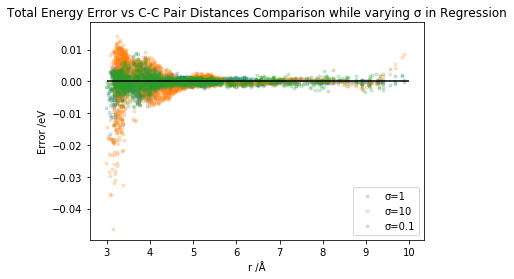

In [216]:
plt.scatter(X.T[2][X.T[2] != 0][::2], fitted_energies-energies,marker=".", alpha=0.2, label="σ=1")
plt.scatter(X.T[2][X.T[2] != 0][::2], fitted_energies_sigma10-energies,marker=".", alpha=0.2, label="σ=10")
plt.scatter(X.T[2][X.T[2] != 0][::2], fitted_energies_sigma_tenth-energies,marker=".", alpha=0.2, label="σ=0.1")
plt.hlines(0, 3,10)
plt.xlabel("r /Å")
plt.ylabel("Error /eV")
plt.title("Total Energy Error vs C-C Pair Distances Comparison while varying σ in Regression")
plt.legend()
plt.show()

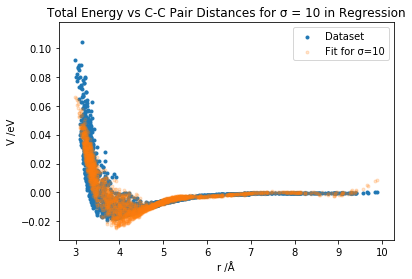

In [217]:
plt.scatter(X.T[2][X.T[2] != 0][::2], energies, marker = ".", label="Dataset")
plt.scatter(X.T[2][X.T[2] != 0][::2], fitted_energies_sigma10,marker=".", label="Fit for σ=10", alpha=0.2)
plt.xlabel("r /Å")
plt.ylabel("V /eV")
plt.title("Total Energy vs C-C Pair Distances for σ = 10 in Regression")
plt.legend()
plt.show()

In [218]:
np.sqrt(np.mean((fitted_energies_sigma10-energies)**2))/2

0.0026037303880120425

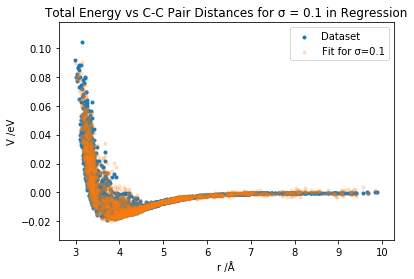

In [219]:
plt.scatter(X.T[2][X.T[2] != 0][::2], energies, marker = ".", label="Dataset")
plt.scatter(X.T[2][X.T[2] != 0][::2], fitted_energies_sigma_tenth,marker=".", label="Fit for σ=0.1", alpha=0.2)
plt.xlabel("r /Å")
plt.ylabel("V /eV")
plt.title("Total Energy vs C-C Pair Distances for σ = 0.1 in Regression")
plt.legend()
plt.show()

In [220]:
np.sqrt(np.mean((fitted_energies_sigma_tenth-energies)**2))/2

0.000889619845911631

### Pair Potentials

In [34]:
from ase import Atoms
pos_base = np.block([np.array([-0.5, 0.5])[:, np.newaxis], np.zeros((2, 2))])

def make_pairpot_dimers(rs, Z1, Z2):
    dimers = []
    cell = np.ones((3,)) * 30
    for r in rs:
        dimers.append(Atoms(numbers=(Z1, Z2), positions=((pos_base * r) + cell/2), cell=cell))
    return dimers

In [46]:
rs_CC = np.linspace(0.5, 10, 2418)
dimers_CC = make_pairpot_dimers(rs_CC, 6, 6)  # C-C

In [47]:
CC_rep = pd.transform(dimers_CC)
CC_X = CC_rep.get_features(pd)
CC_kernel = k0_8.__call__(CC_rep, rep)

In [48]:
norm_CC_kernel = CC_kernel / (2*np.sqrt(k0_8_diags))

In [475]:
opt_alpha = new_kernel_regression(energies, norm_kernel_matrix0_8, 0.03)

/local/home/local/miniconda3/envs/librascal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [476]:
np.linalg.cond(norm_CC_kernel + np.eye(len(norm_CC_kernel[0])))

1130.1787769468506

In [477]:
opt_energies = energy_fit(norm_kernel_matrix0_8, opt_alpha)

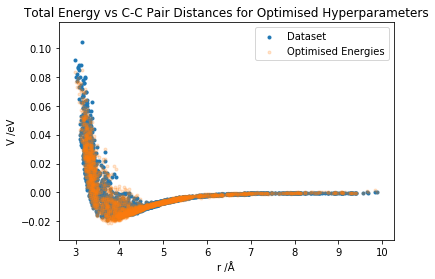

In [478]:
plt.scatter(X.T[2][X.T[2] != 0][::2], energies, marker = ".", label="Dataset")
plt.scatter(X.T[2][X.T[2] != 0][::2], opt_energies,marker=".", label="Optimised Energies", alpha=0.2)
plt.xlabel("r /Å")
plt.ylabel("V /eV")
plt.title("Total Energy vs C-C Pair Distances for Optimised Hyperparameters")
plt.legend()
plt.show()

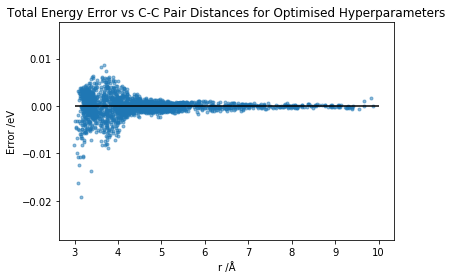

In [479]:
plt.scatter(X.T[2][X.T[2] != 0][::2], opt_energies-energies,marker=".", alpha=0.5)
plt.hlines(0, 3,10)
plt.xlabel("r /Å")
plt.ylabel("Error /eV")
plt.title("Total Energy Error vs C-C Pair Distances for Optimised Hyperparameters")
plt.show()

In [480]:
np.sqrt(np.mean((opt_energies-energies)**2))/2

0.0010198095149417242

In [481]:
CC_energies = energy_fit(norm_CC_kernel, opt_alpha)

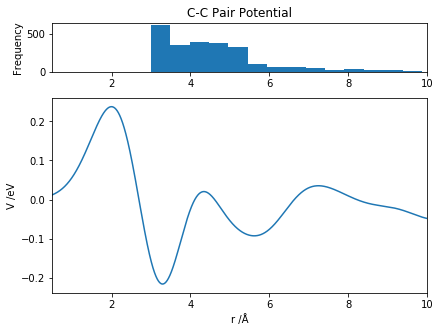

In [482]:
fig = plt.figure(figsize=(6,4.5), constrained_layout=True)

heights = [1, 4]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

axs=[]
axs0 = fig.add_subplot(spec[0,0])
axs1 = fig.add_subplot(spec[1,0])
axs.append(axs0)
axs.append(axs1)

axs[0].hist(CC_dist, bins = CCn)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0.5,10)
axs[0].set_title("C-C Pair Potential")

axs[1].plot(CC_X[::2], CC_energies,marker="", linestyle="-")
axs[1].set_ylabel("V /eV")
axs[1].set_xlim(0.5,10)

plt.xlabel("r /Å")

plt.show()

In [197]:
rs_CH = np.linspace(0.5, 10, 2418)
dimers_CH = make_pairpot_dimers(rs_CH, 6, 1)  # C-H
CH_rep = pd.transform(dimers_CH)
CH_X = CH_rep.get_features(pd)
CH_kernel = k0_8.__call__(CH_rep,rep)

In [468]:
norm_CH_kernel = CH_kernel / (2*np.sqrt(k0_8_diags))

In [483]:
CH_energies = energy_fit(norm_CH_kernel, opt_alpha)

In [484]:
np.linalg.cond(norm_CH_kernel + np.eye(len(norm_CH_kernel[0])))

2971902.3574799523

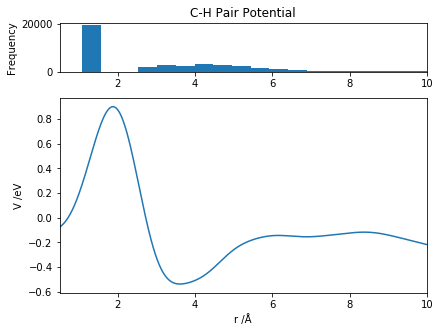

In [485]:
fig = plt.figure(figsize=(6,4.5), constrained_layout=True)

heights = [1, 4]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

axs=[]
axs0 = fig.add_subplot(spec[0,0])
axs1 = fig.add_subplot(spec[1,0])
axs.append(axs0)
axs.append(axs1)

axs[0].hist(CH_dist, bins = CHn)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0.5,10)
axs[0].set_title("C-H Pair Potential")

axs[1].plot(rs_CH, CH_energies,marker="", linestyle="-")
axs[1].set_ylabel("V /eV")
axs[1].set_xlim(0.5,10)

plt.xlabel("r /Å")

plt.show()

In [202]:
rs_HH = np.linspace(0.5, 10, 2418)
dimers_HH = make_pairpot_dimers(rs_HH, 1, 1)  # H-H
HH_rep = pd.transform(dimers_HH)
HH_X = HH_rep.get_features(pd)
HH_kernel = k0_8.__call__(HH_rep,rep)

In [456]:
norm_HH_kernel = HH_kernel / (2*np.sqrt(k0_8_diags))

In [486]:
HH_energies = energy_fit(norm_HH_kernel, opt_alpha)

In [487]:
np.linalg.cond(norm_HH_kernel + np.eye(len(norm_HH_kernel[0])))

260267.65076725435

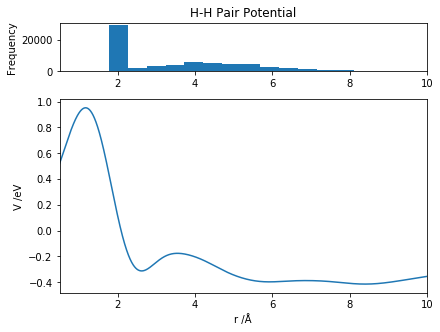

In [488]:
fig = plt.figure(figsize=(6,4.5), constrained_layout=True)

heights = [1, 4]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

axs=[]
axs0 = fig.add_subplot(spec[0,0])
axs1 = fig.add_subplot(spec[1,0])
axs.append(axs0)
axs.append(axs1)

axs[0].hist(HH_dist, bins = HHn)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0.5,10)
axs[0].set_title("H-H Pair Potential")

axs[1].plot(HH_X[::2], HH_energies,marker="", linestyle="-")
axs[1].set_ylabel("V /eV")
axs[1].set_xlim(0.5,10)

plt.xlabel("r /Å")

plt.show()

In [211]:
from math import ceil

Text(0, 0.5, 'Frequency')

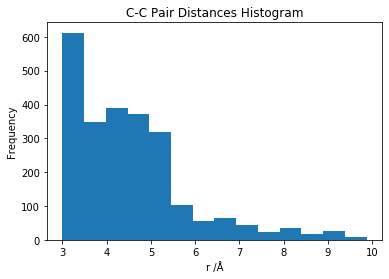

In [216]:
w = 0.5
CCn = ceil((CC_dist.max() - CC_dist.min())/w)
plt.hist(CC_dist, bins = CCn)
plt.title("C-C Pair Distances Histogram")
plt.xlabel("r /Å")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

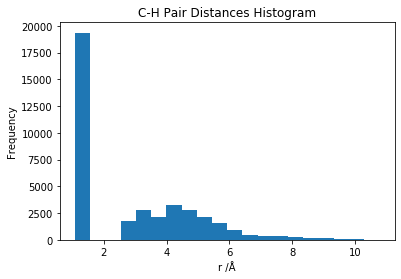

In [215]:
w = 0.5
CHn = ceil((CH_dist.max() - CH_dist.min())/w)
plt.hist(CH_dist, bins = CHn)
plt.title("C-H Pair Distances Histogram")
plt.xlabel("r /Å")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

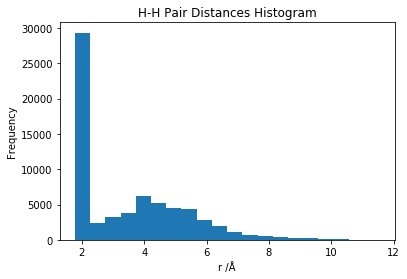

In [217]:
HHn = ceil((HH_dist.max() - HH_dist.min())/w)
plt.hist(HH_dist, bins = HHn)
plt.title("H-H Pair Distances Histogram")
plt.xlabel("r /Å")
plt.ylabel("Frequency")

### Cross Validation

In [866]:
import random as rd
randomised_list = list(range(2418))
rd.shuffle(randomised_list)

In [1229]:
randomised_kernel = []
randomised_energies = []
for i in randomised_list:
    row = []
    for j in randomised_list:
        row.append(kernel_matrix0_8[i][j])
    randomised_kernel.append(row)
    randomised_energies.append(energies[i])
randomised_kernel = np.asarray(randomised_kernel)
randomised_energies = np.asarray(randomised_energies)

In [19]:
log_regulariser_values=np.linspace(-8,2,100)

In [1234]:
randomised_log_regulariser_rmse=[]
for log_value in log_regulariser_values:
    cv_rmse=[]
    for i in range(6):
        cv_train_kernel = np.delete(np.delete(randomised_kernel, np.s_[(i*403):((i+1)*403)], 0), np.s_[(i*403):((i+1)*403)], 1)
        cv_test_kernel = np.delete(randomised_kernel[(i*403):((i+1)*403)], np.s_[(i*403):((i+1)*403)], 1)
        train_energies = np.delete(randomised_energies, np.s_[(i*403):((i+1)*403)], 0)
        test_energies = randomised_energies[(i*403):((i+1)*403)]

        train_alpha = new_kernel_regression(train_energies, cv_train_kernel, np.exp(log_value))
        test_fitted_energies = energy_fit(cv_test_kernel, train_alpha)
        cv_rmse.append(np.sqrt(np.mean((test_fitted_energies-test_energies)**2))/2) 
    randomised_log_regulariser_rmse.append(np.mean(cv_rmse))

/local/home/local/miniconda3/envs/librascal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [20]:
log_regulariser_rmse=[]
for log_value in log_regulariser_values:
    cv_rmse=[]
    for i in range(6):
        cv_train_kernel = np.delete(np.delete(norm_kernel_matrix0_8, np.s_[(i*403):((i+1)*403)], 0), np.s_[(i*403):((i+1)*403)], 1)
        cv_test_kernel = np.delete(norm_kernel_matrix0_8[(i*403):((i+1)*403)], np.s_[(i*403):((i+1)*403)], 1)
        train_energies = np.delete(energies, np.s_[(i*403):((i+1)*403)], 0)
        test_energies = energies[(i*403):((i+1)*403)]

        train_alpha = new_kernel_regression(train_energies, cv_train_kernel, np.exp(log_value))
        test_fitted_energies = energy_fit(cv_test_kernel, train_alpha)
        cv_rmse.append(np.sqrt(np.mean((test_fitted_energies-test_energies)**2))/2) 
    log_regulariser_rmse.append(np.mean(cv_rmse))

/local/home/local/miniconda3/envs/librascal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


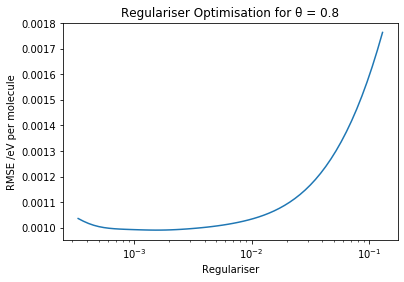

In [761]:
plt.plot(np.exp(log_regulariser_values[:60]), log_regulariser_rmse[:60])
plt.xlabel("Regulariser")
plt.ylabel("RMSE /eV per molecule")
plt.title("Regulariser Optimisation for θ = 0.8")
plt.xscale("log")
plt.show()

In [31]:
min(log_regulariser_rmse)

0.0009906869995682046

In [32]:
log_regulariser_rmse.index(0.0009906869995682046)

15

In [185]:
np.exp(log_regulariser_values[15])

0.0015263920206454425

In [188]:
print(np.exp(log_regulariser_values[30]))
print(log_regulariser_rmse[30])

0.006945252337816761
0.0010170343628849734


In [187]:
print(np.exp(log_regulariser_values[40]))
print(log_regulariser_rmse[40])

0.019070818116235694
0.0010871505117674663


In [71]:
log_regulariser_rmse6=[]
for log_value in log_regulariser_values:
    cv_rmse=[]
    for i in range(6):
        cv_train_kernel = np.delete(np.delete(norm_kernel6, np.s_[(i*403):((i+1)*403)], 0), np.s_[(i*403):((i+1)*403)], 1)
        cv_test_kernel = np.delete(norm_kernel6[(i*403):((i+1)*403)], np.s_[(i*403):((i+1)*403)], 1)
        train_energies = np.delete(energies, np.s_[(i*403):((i+1)*403)], 0)
        test_energies = energies[(i*403):((i+1)*403)]

        train_alpha = new_kernel_regression(train_energies, cv_train_kernel, np.exp(log_value))
        test_fitted_energies = energy_fit(cv_test_kernel, train_alpha)
        cv_rmse.append(np.sqrt(np.mean((test_fitted_energies-test_energies)**2))/2) 
    log_regulariser_rmse6.append(np.mean(cv_rmse))

/local/home/local/miniconda3/envs/librascal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


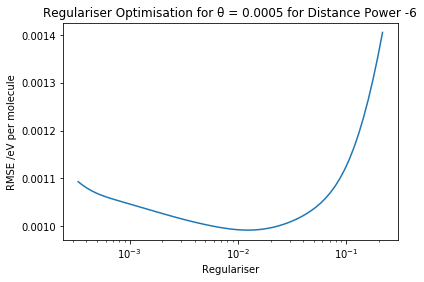

In [762]:
plt.plot(np.exp(log_regulariser_values[:65]), log_regulariser_rmse6[:65])
plt.xlabel("Regulariser")
plt.ylabel("RMSE /eV per molecule")
plt.title("Regulariser Optimisation for θ = 0.0005 for Distance Power -6")
plt.xscale("log")
plt.show()

In [73]:
min(log_regulariser_rmse6)

0.0009920512304407185

In [80]:
log_regulariser_rmse6.index(0.0009920512304407185)

36

In [81]:
np.exp(log_regulariser_values[36])

0.012732005168249957

In [274]:
print(np.exp(log_regulariser_values[40]))
print(log_regulariser_rmse6[40])

0.019070818116235694
0.000995941082563587


In [275]:
print(np.exp(log_regulariser_values[50]))
print(log_regulariser_rmse6[50])

0.0523661468197815
0.001040149661114366


In [74]:
log_regulariser_rmse12=[]
for log_value in log_regulariser_values:
    cv_rmse=[]
    for i in range(6):
        cv_train_kernel = np.delete(np.delete(norm_kernel12, np.s_[(i*403):((i+1)*403)], 0), np.s_[(i*403):((i+1)*403)], 1)
        cv_test_kernel = np.delete(norm_kernel12[(i*403):((i+1)*403)], np.s_[(i*403):((i+1)*403)], 1)
        train_energies = np.delete(energies, np.s_[(i*403):((i+1)*403)], 0)
        test_energies = energies[(i*403):((i+1)*403)]

        train_alpha = new_kernel_regression(train_energies, cv_train_kernel, np.exp(log_value))
        test_fitted_energies = energy_fit(cv_test_kernel, train_alpha)
        cv_rmse.append(np.sqrt(np.mean((test_fitted_energies-test_energies)**2))/2) 
    log_regulariser_rmse12.append(np.mean(cv_rmse))

/local/home/local/miniconda3/envs/librascal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


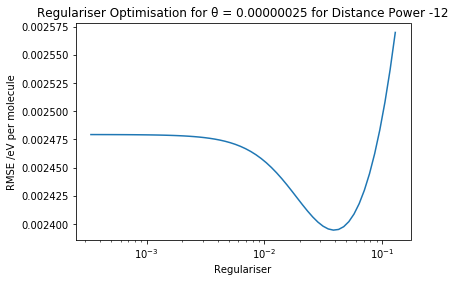

In [752]:
plt.plot(np.exp(log_regulariser_values[:60]), log_regulariser_rmse12[:60])
plt.xlabel("Regulariser")
plt.ylabel("RMSE /eV per molecule")
plt.title("Regulariser Optimisation for θ = 0.00000025 for Distance Power -12")
plt.xscale("log")
plt.show()

In [76]:
min(log_regulariser_rmse12)

0.0023945169623126547

In [82]:
log_regulariser_rmse12.index(0.0023945169623126547)

47

In [83]:
np.exp(log_regulariser_values[47])

0.038676416691109695

In [77]:
log_regulariser_rmse612=[]
for log_value in log_regulariser_values:
    cv_rmse=[]
    for i in range(6):
        cv_train_kernel = np.delete(np.delete(norm_kernel6_12, np.s_[(i*403):((i+1)*403)], 0), np.s_[(i*403):((i+1)*403)], 1)
        cv_test_kernel = np.delete(norm_kernel6_12[(i*403):((i+1)*403)], np.s_[(i*403):((i+1)*403)], 1)
        train_energies = np.delete(energies, np.s_[(i*403):((i+1)*403)], 0)
        test_energies = energies[(i*403):((i+1)*403)]

        train_alpha = new_kernel_regression(train_energies, cv_train_kernel, np.exp(log_value))
        test_fitted_energies = energy_fit(cv_test_kernel, train_alpha)
        cv_rmse.append(np.sqrt(np.mean((test_fitted_energies-test_energies)**2))/2) 
    log_regulariser_rmse612.append(np.mean(cv_rmse))

/local/home/local/miniconda3/envs/librascal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


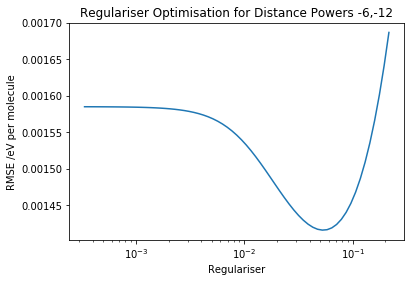

In [755]:
plt.plot(np.exp(log_regulariser_values[:65]), log_regulariser_rmse612[:65])
plt.xlabel("Regulariser")
plt.ylabel("RMSE /eV per molecule")
plt.title("Regulariser Optimisation for Distance Powers -6,-12")
plt.xscale("log")
plt.show()

In [79]:
min(log_regulariser_rmse612)

0.001415662836969502

In [84]:
log_regulariser_rmse612.index(0.001415662836969502)

50

In [85]:
np.exp(log_regulariser_values[50])

0.0523661468197815

### Inverse-power functionality

In [22]:
for dim in samples:
    cell_extents = (np.max(dim.get_positions(), axis=0)
                    - np.min(dim.get_positions(), axis=0)
                    + np.array([30, 30, 30]))
    dim.set_cell(cell_extents)
    dim.set_positions(dim.get_positions()-np.mean(dim.get_positions(),axis=0))
    dim.set_positions(dim.get_positions() + cell_extents / 2.)

In [109]:
samples[0].get_positions()

array([[17.28714575, 18.83153068, 15.85130521],
       [17.23097228, 18.33223502, 16.81650221],
       [16.99902414, 18.13554565, 15.06623077],
       [18.30587574, 19.17224539, 15.67853113],
       [16.61275794, 19.68543719, 15.84486116],
       [15.93403641, 15.76036424, 19.14633323],
       [16.45766264, 15.5002943 , 20.06404539],
       [16.61172162, 15.65941697, 18.30097534],
       [15.58213377, 16.78818457, 19.20834781],
       [15.08467473, 15.09365533, 19.01194083]])

In [221]:
pd_dist_pow = PairDistances(interaction_cutoff=12.0, cutoff_smooth_width=0.5, n_species=2,
                   distance_powers=[-6,-12])

In [222]:
rep_dist_pow = pd_dist_pow.transform(samples)

In [223]:
X_dist_pow = rep_dist_pow.get_features(pd_dist_pow)

Now you see the same distances, taken to the specified powers.  Since we specified two exponents, the columns are doubled.

In [224]:
X_dist_pow[:90]

array([[0.00000000e+00, 0.00000000e+00, 6.02396335e-01, 3.62881345e-01,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.02863253e-01, 3.63444102e-01,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.02867702e-01, 3.63449466e-01,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.02488061e-01, 3.62991863e-01,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        9.23919551e-05, 8.53627336e-09],
       [0.00000000e+00, 0.00000000e+00, 3.88244786e-05, 1.50734014e-09,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.21828951e-04, 4.92080836e-08,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.61787603e-04, 2.61752285e-08,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.18090563e-05, 1.74799719e-09,
        0.00000000e+00, 

Let's take a look at just the C-C columns:

In [72]:
np.sum?

In [225]:
cc_powers = X_dist_pow[:90,4:]
cc_powers = cc_powers[np.any((cc_powers != 0), axis=1)]

In [226]:
cc_powers

array([[9.23919551e-05, 8.53627336e-09],
       [9.23919551e-05, 8.53627336e-09]])

In [227]:
samples[0].get_distance(0, 5)**-6

9.239195508212514e-05

In [229]:
samples[0].get_distance(0, 5)**-12

8.53627336389743e-09

which correspond to the first and second numbers in these columns.

In [23]:
pd_dist_pow6 = PairDistances(interaction_cutoff=12.0, cutoff_smooth_width=0.5, n_species=2,
                   distance_powers=[-6])
rep_dist_pow6 = pd_dist_pow6.transform(samples)
X_dist_pow6 = rep_dist_pow6.get_features(pd_dist_pow6)
k_dist_pow6 = Kernel(pd_dist_pow6, name="Gaussian", target_type="Structure",theta=0.0005)
kernel_matrix_dist_pow6=k_dist_pow6.__call__(rep_dist_pow6, rep_dist_pow6)

In [24]:
diags6 = np.diag(kernel_matrix_dist_pow6)

In [25]:
norm_kernel6 = kernel_matrix_dist_pow6 / np.sqrt(np.outer(diags6, diags6))

In [1324]:
np.linalg.cond(norm_kernel6 + np.eye(len(norm_kernel6[0])))

2337.003533388685

In [538]:
opt_alpha6 = new_kernel_regression(energies, norm_kernel6, 0.07)
opt_energies6 = energy_fit(norm_kernel6, opt_alpha6)

/local/home/local/miniconda3/envs/librascal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


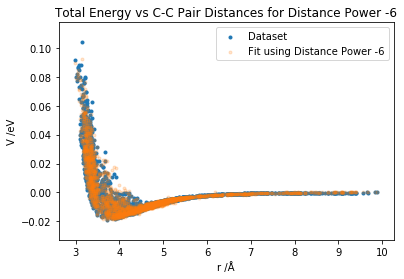

In [539]:
plt.scatter(X.T[2][X.T[2] != 0][::2], energies, marker = ".", label="Dataset")
plt.scatter(X.T[2][X.T[2] != 0][::2], opt_energies6,marker=".", label="Fit using Distance Power -6", alpha=0.2)
plt.xlabel("r /Å")
plt.ylabel("V /eV")
plt.title("Total Energy vs C-C Pair Distances for Distance Power -6")
plt.legend()
plt.show()

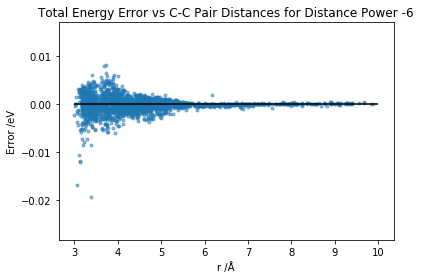

In [540]:
plt.scatter(X.T[2][X.T[2] != 0][::2], opt_energies6-energies,marker=".", alpha=0.5)
plt.hlines(0, 3,10)
plt.xlabel("r /Å")
plt.ylabel("Error /eV")
plt.title("Total Energy Error vs C-C Pair Distances for Distance Power -6")
plt.show()

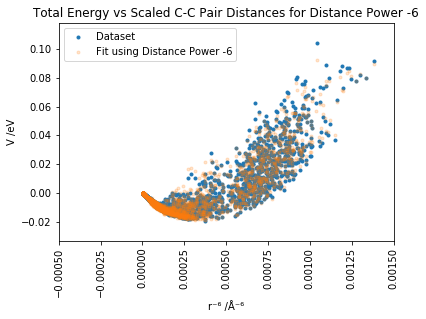

In [667]:
plt.scatter(X_dist_pow6.T[2][X_dist_pow6.T[2] != 0][::2], energies, marker = ".", label="Dataset")
plt.scatter(X_dist_pow6.T[2][X_dist_pow6.T[2] != 0][::2], opt_energies6,marker=".", label="Fit using Distance Power -6", alpha=0.2)
plt.xlabel("r⁻⁶ /Å⁻⁶")
plt.ylabel("V /eV")
plt.xlim(-0.0005,0.0015)
plt.xticks(rotation=90)
plt.title("Total Energy vs Scaled C-C Pair Distances for Distance Power -6")
plt.legend()
plt.show()

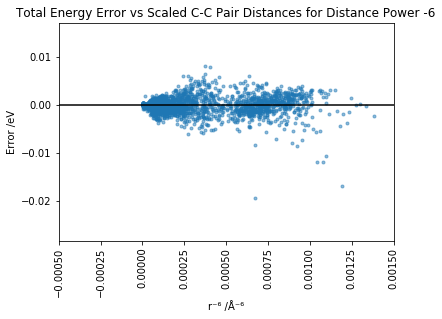

In [674]:
plt.scatter(X_dist_pow6.T[2][X_dist_pow6.T[2] != 0][::2], opt_energies6-energies,marker=".", alpha=0.5)
plt.xlim(-0.0005,0.0015)
plt.hlines(0, -1,10)
plt.xticks(rotation=90)
plt.xlabel("r⁻⁶ /Å⁻⁶")
plt.ylabel("Error /eV")
plt.title("Total Energy Error vs Scaled C-C Pair Distances for Distance Power -6")
plt.show()

In [541]:
np.sqrt(np.mean((opt_energies6-energies)**2))/2

0.0008627303654869996

In [26]:
pd_dist_pow12 = PairDistances(interaction_cutoff=12.0, cutoff_smooth_width=0.5, n_species=2,
                   distance_powers=[-12])
rep_dist_pow12 = pd_dist_pow12.transform(samples)
X_dist_pow12 = rep_dist_pow12.get_features(pd_dist_pow12)
k_dist_pow12 = Kernel(pd_dist_pow12, name="Gaussian", target_type="Structure",theta=0.00000025)
kernel_matrix_dist_pow12=k_dist_pow12.__call__(rep_dist_pow12, rep_dist_pow12)

In [27]:
diags12 = np.diag(kernel_matrix_dist_pow12)

In [28]:
norm_kernel12 = kernel_matrix_dist_pow12 / np.sqrt(np.outer(diags12, diags12))

In [29]:
np.linalg.cond(norm_kernel12 + np.eye(len(norm_kernel12[0])))

1794.5703712765928

In [565]:
#0.0387
opt_alpha12 = new_kernel_regression(energies, norm_kernel12,0.06)
opt_energies12 = energy_fit(norm_kernel12, opt_alpha12)

/local/home/local/miniconda3/envs/librascal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


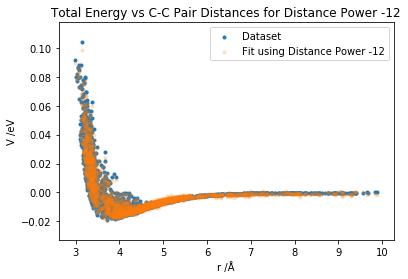

In [566]:
plt.scatter(X.T[2][X.T[2] != 0][::2], energies, marker = ".", label="Dataset")
plt.scatter(X.T[2][X.T[2] != 0][::2], opt_energies12,marker=".", label="Fit using Distance Power -12", alpha=0.2)
plt.xlabel("r /Å")
plt.ylabel("V /eV")
plt.title("Total Energy vs C-C Pair Distances for Distance Power -12")
plt.legend()
plt.show()

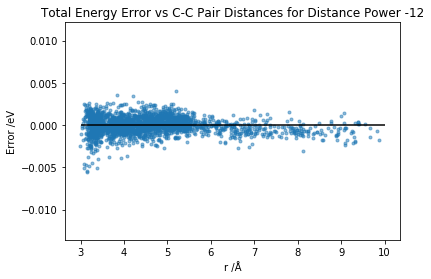

In [567]:
plt.scatter(X.T[2][X.T[2] != 0][::2], opt_energies12-energies,marker=".", alpha=0.5)
plt.hlines(0, 3,10)
plt.xlabel("r /Å")
plt.ylabel("Error /eV")
plt.title("Total Energy Error vs C-C Pair Distances for Distance Power -12")
plt.show()

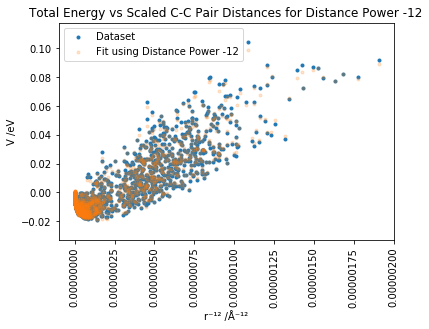

In [675]:
plt.scatter(X_dist_pow12.T[2][X_dist_pow12.T[2] != 0][::2], energies, marker = ".", label="Dataset")
plt.scatter(X_dist_pow12.T[2][X_dist_pow12.T[2] != 0][::2], opt_energies12,marker=".", label="Fit using Distance Power -12", alpha=0.2)
plt.xlabel("r⁻¹² /Å⁻¹²")
plt.ylabel("V /eV")
plt.xlim(-0.0000001,0.000002)
plt.xticks(rotation=90)
plt.title("Total Energy vs Scaled C-C Pair Distances for Distance Power -12")
plt.legend()
plt.show()

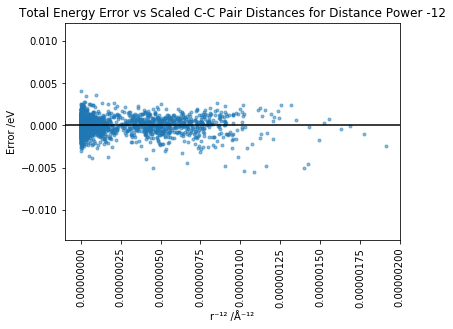

In [676]:
plt.scatter(X_dist_pow12.T[2][X_dist_pow12.T[2] != 0][::2], opt_energies12-energies,marker=".", alpha=0.5)
plt.xlim(-0.0000001,0.000002)
plt.hlines(0, -1,10)
plt.xticks(rotation=90)
plt.xlabel("r⁻¹² /Å⁻¹²")
plt.ylabel("Error /eV")
plt.title("Total Energy Error vs Scaled C-C Pair Distances for Distance Power -12")
plt.show()

In [568]:
np.sqrt(np.mean((opt_energies12-energies)**2))/2

0.0004991333068845187

In [158]:
CC_dist6 = X_dist_pow6.T[2][X_dist_pow6.T[2] != 0][::2]

Text(0, 0.5, 'Frequency')

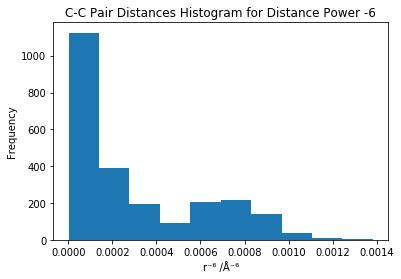

In [222]:
plt.hist(CC_dist6)
plt.title("C-C Pair Distances Histogram for Distance Power -6")
plt.xlabel("r⁻⁶ /Å⁻⁶")
plt.ylabel("Frequency")

In [161]:
CH_dist6 = X_dist_pow6.T[1][X_dist_pow6.T[1] != 0]
CH_dist6.sort()
CH_dist6 = CH_dist6[::2]

Text(0, 0.5, 'Frequency')

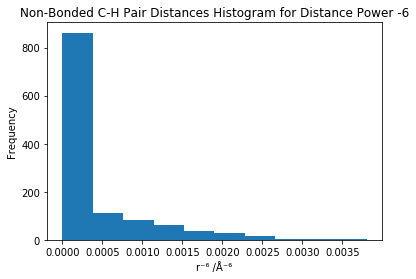

In [163]:
plt.hist(X_dist_pow6.T[1][(X_dist_pow6.T[1] != 0) & (X_dist_pow6.T[1] < 0.3)][4::32])
plt.title("Non-Bonded C-H Pair Distances Histogram for Distance Power -6")
plt.xlabel("r⁻⁶ /Å⁻⁶")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

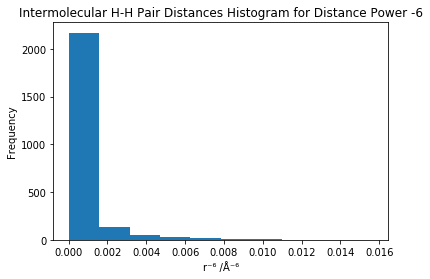

In [609]:
plt.hist(X_dist_pow6.T[0][X_dist_pow6.T[0] != 0][3::56])
plt.title("Intermolecular H-H Pair Distances Histogram for Distance Power -6")
plt.xlabel("r⁻⁶ /Å⁻⁶")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

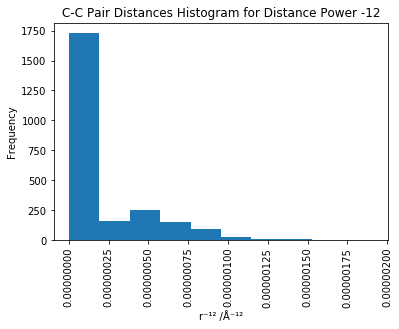

In [610]:
plt.hist(X_dist_pow12.T[2][X_dist_pow12.T[2] != 0][::2])
plt.title("C-C Pair Distances Histogram for Distance Power -12")
plt.xticks(rotation=90)
plt.xlabel("r⁻¹² /Å⁻¹²")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

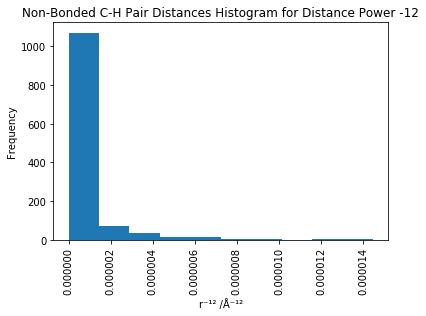

In [611]:
plt.hist(X_dist_pow12.T[1][(X_dist_pow12.T[1] != 0) & (X_dist_pow12.T[1] < 0.3)][4::32])
plt.title("Non-Bonded C-H Pair Distances Histogram for Distance Power -12")
plt.xticks(rotation=90)
plt.xlabel("r⁻¹² /Å⁻¹²")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

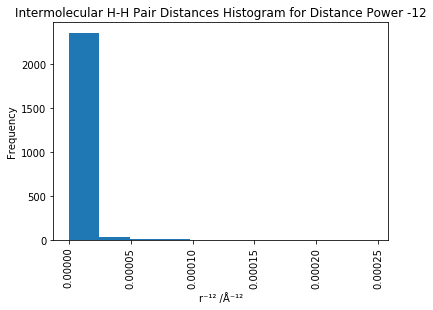

In [164]:
plt.hist(X_dist_pow12.T[0][X_dist_pow12.T[0] != 0][3::56])
plt.title("Intermolecular H-H Pair Distances Histogram for Distance Power -12")
plt.xticks(rotation=90)
plt.xlabel("r⁻¹² /Å⁻¹²")
plt.ylabel("Frequency")

In [542]:
CC_rep_dist_pow6 = pd_dist_pow6.transform(dimers_CC)
CC_X_dist_pow6 = CC_rep_dist_pow6.get_features(pd_dist_pow6)
CC_k_dist_pow6 = k_dist_pow6.__call__(CC_rep_dist_pow6,rep_dist_pow6)

In [543]:
norm_CC_k6 = CC_k_dist_pow6 / (2*np.sqrt(diags6))
CC_energies_dist_pow6 = energy_fit(norm_CC_k6, opt_alpha6)

In [544]:
np.linalg.cond(norm_CC_k6 + np.eye(len(norm_CC_k6[0])))

324.75336636420764

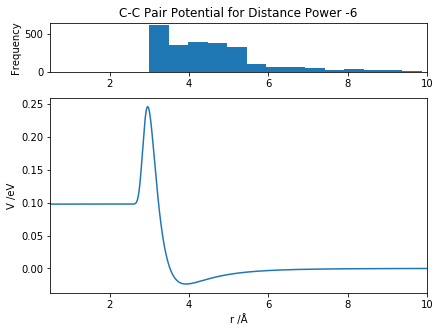

In [710]:
fig = plt.figure(figsize=(6,4.5), constrained_layout=True)

heights = [1, 4]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

axs=[]
axs0 = fig.add_subplot(spec[0,0])
axs1 = fig.add_subplot(spec[1,0])
axs.append(axs0)
axs.append(axs1)

axs[0].hist(CC_dist, bins = CCn)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0.5,10)
axs[0].set_title("C-C Pair Potential for Distance Power -6")

axs[1].plot(CC_X[::2], CC_energies_dist_pow6-CC_energies_dist_pow6[-1],marker="", linestyle="-")
axs[1].set_ylabel("V /eV")
axs[1].set_xlim(0.5,10)

plt.xlabel("r /Å")

plt.show()

In [712]:
np.min(CC_energies_dist_pow6-CC_energies_dist_pow6[-1])

-0.02360531108958612

In [103]:
CH_rep_dist_pow6 = pd_dist_pow6.transform(dimers_CH)
CH_X_dist_pow6 = CH_rep_dist_pow6.get_features(pd_dist_pow6)
CH_k_dist_pow6 = k_dist_pow6.__call__(CH_rep_dist_pow6,rep_dist_pow6)

In [546]:
norm_CH_k6 = CH_k_dist_pow6 / (2*np.sqrt(diags6))
CH_energies_dist_pow6 = energy_fit(norm_CH_k6, opt_alpha6)

In [547]:
np.linalg.cond(norm_CH_k6 + np.eye(len(norm_CH_k6[0])))

11746.084491110245

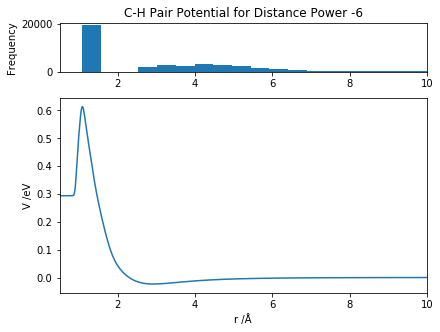

In [711]:
fig = plt.figure(figsize=(6,4.5), constrained_layout=True)

heights = [1, 4]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

axs=[]
axs0 = fig.add_subplot(spec[0,0])
axs1 = fig.add_subplot(spec[1,0])
axs.append(axs0)
axs.append(axs1)

axs[0].hist(CH_dist, bins = CHn)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0.5,10)
axs[0].set_title("C-H Pair Potential for Distance Power -6")

axs[1].plot(CH_X[::2], CH_energies_dist_pow6-CH_energies_dist_pow6[-1],marker="", linestyle="-")
axs[1].set_ylabel("V /eV")
axs[1].set_xlim(0.5,10)

plt.xlabel("r /Å")

plt.show()

In [713]:
np.min(CH_energies_dist_pow6-CH_energies_dist_pow6[-1])

-0.023301647405992776

In [107]:
HH_rep_dist_pow6 = pd_dist_pow6.transform(dimers_HH)
HH_X_dist_pow6 = HH_rep_dist_pow6.get_features(pd_dist_pow6)
HH_k_dist_pow6 = k_dist_pow6.__call__(HH_rep_dist_pow6,rep_dist_pow6)

In [549]:
norm_HH_k6 = HH_k_dist_pow6 / (2*np.sqrt(diags6))
HH_energies_dist_pow6 = energy_fit(norm_HH_k6, opt_alpha6)

In [550]:
np.linalg.cond(norm_HH_k6 + np.eye(len(norm_HH_k6[0])))

18449.218742477515

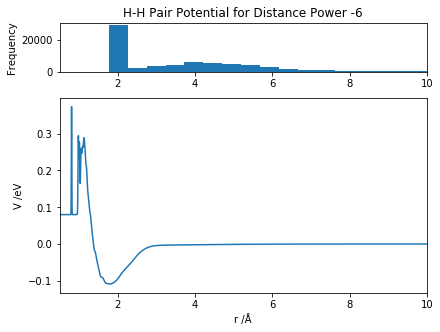

In [714]:
fig = plt.figure(figsize=(6,4.5), constrained_layout=True)

heights = [1, 4]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

axs=[]
axs0 = fig.add_subplot(spec[0,0])
axs1 = fig.add_subplot(spec[1,0])
axs.append(axs0)
axs.append(axs1)

axs[0].hist(HH_dist, bins = HHn)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0.5,10)
axs[0].set_title("H-H Pair Potential for Distance Power -6")

axs[1].plot(HH_X[::2], HH_energies_dist_pow6-HH_energies_dist_pow6[-1],marker="", linestyle="-")
axs[1].set_ylabel("V /eV")
axs[1].set_xlim(0.5,10)

plt.xlabel("r /Å")

plt.show()

In [715]:
np.min(HH_energies_dist_pow6-HH_energies_dist_pow6[-1])

-0.10883568291883261

In [111]:
CC_rep_dist_pow12 = pd_dist_pow12.transform(dimers_CC)
CC_X_dist_pow12 = CC_rep_dist_pow12.get_features(pd_dist_pow12)
CC_k_dist_pow12 = k_dist_pow12.__call__(CC_rep_dist_pow12,rep_dist_pow12)

In [569]:
norm_CC_k12 = CC_k_dist_pow12 / (2*np.sqrt(diags12))
CC_energies_dist_pow12 = energy_fit(norm_CC_k12, opt_alpha12)

In [570]:
np.linalg.cond(norm_CC_k12 + np.eye(len(norm_CC_k12[0])))

586.9223061636022

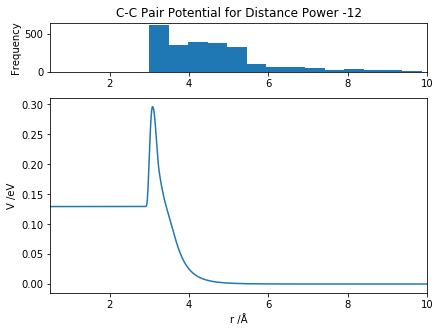

In [716]:
fig = plt.figure(figsize=(6,4.5), constrained_layout=True)

heights = [1, 4]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

axs=[]
axs0 = fig.add_subplot(spec[0,0])
axs1 = fig.add_subplot(spec[1,0])
axs.append(axs0)
axs.append(axs1)

axs[0].hist(CC_dist, bins = CCn)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0.5,10)
axs[0].set_title("C-C Pair Potential for Distance Power -12")

axs[1].plot(CC_X[::2], CC_energies_dist_pow12-CC_energies_dist_pow12[-1],marker="", linestyle="-")
axs[1].set_ylabel("V /eV")
axs[1].set_xlim(0.5,10)

plt.xlabel("r /Å")

plt.show()

In [718]:
np.min(CC_energies_dist_pow12-CC_energies_dist_pow12[-1])

0.0

In [115]:
CH_rep_dist_pow12 = pd_dist_pow12.transform(dimers_CH)
CH_X_dist_pow12 = CH_rep_dist_pow12.get_features(pd_dist_pow12)
CH_k_dist_pow12 = k_dist_pow12.__call__(CH_rep_dist_pow12,rep_dist_pow12)

In [572]:
norm_CH_k12 = CH_k_dist_pow12 / (2*np.sqrt(diags12))
CH_energies_dist_pow12 = energy_fit(norm_CH_k12, opt_alpha12)

In [573]:
np.linalg.cond(norm_CH_k12 + np.eye(len(norm_CH_k12[0])))

9786.71312077477

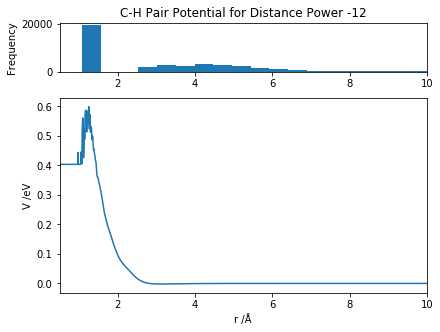

In [717]:
fig = plt.figure(figsize=(6,4.5), constrained_layout=True)

heights = [1, 4]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

axs=[]
axs0 = fig.add_subplot(spec[0,0])
axs1 = fig.add_subplot(spec[1,0])
axs.append(axs0)
axs.append(axs1)

axs[0].hist(CH_dist, CHn)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0.5,10)
axs[0].set_title("C-H Pair Potential for Distance Power -12")

axs[1].plot(CH_X[::2], CH_energies_dist_pow12-CH_energies_dist_pow12[-1],marker="", linestyle="-")
axs[1].set_ylabel("V /eV")
axs[1].set_xlim(0.5,10)

plt.xlabel("r /Å")

plt.show()

In [719]:
np.min(CH_energies_dist_pow12-CH_energies_dist_pow12[-1])

-0.0020545239639340185

In [119]:
HH_rep_dist_pow12 = pd_dist_pow12.transform(dimers_HH)
HH_X_dist_pow12 = HH_rep_dist_pow12.get_features(pd_dist_pow12)
HH_k_dist_pow12 = k_dist_pow12.__call__(HH_rep_dist_pow12,rep_dist_pow12)

In [575]:
norm_HH_k12 = HH_k_dist_pow12 / (2*np.sqrt(diags12))
HH_energies_dist_pow12 = energy_fit(norm_HH_k12, opt_alpha12)

In [576]:
np.linalg.cond(norm_HH_k12 + np.eye(len(norm_HH_k12[0])))

22744.834795407874

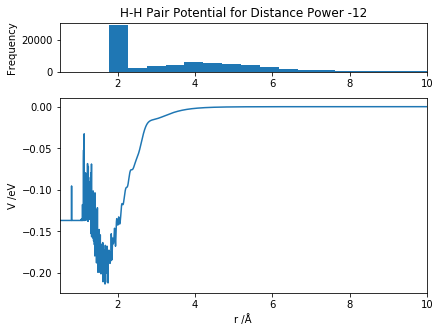

In [720]:
fig = plt.figure(figsize=(6,4.5), constrained_layout=True)

heights = [1, 4]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

axs=[]
axs0 = fig.add_subplot(spec[0,0])
axs1 = fig.add_subplot(spec[1,0])
axs.append(axs0)
axs.append(axs1)

axs[0].hist(HH_dist, bins = HHn)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0.5,10)
axs[0].set_title("H-H Pair Potential for Distance Power -12")

axs[1].plot(HH_X[::2], HH_energies_dist_pow12-HH_energies_dist_pow12[-1],marker="", linestyle="-")
axs[1].set_ylabel("V /eV")
axs[1].set_xlim(0.5,10)

plt.xlabel("r /Å")

plt.show()

In [721]:
np.min(HH_energies_dist_pow12-HH_energies_dist_pow12[-1])

-0.21362701741829604

In [700]:
print(CH_X[::2][400])
print(HH_X[::2][500])

[2.07219694]
[2.46524617]


In [706]:
total_potential6 = (CC_energies_dist_pow6[500:]*len(CC_energies_dist_pow6)
                    + CH_energies_dist_pow6[500:]*len(CH_energies_dist_pow6[400:])
                    + HH_energies_dist_pow6[500:]*len(HH_energies_dist_pow6[500:])) /(len(CC_energies_dist_pow6)+len(CH_energies_dist_pow6[400:])+len(HH_energies_dist_pow6[500:]))

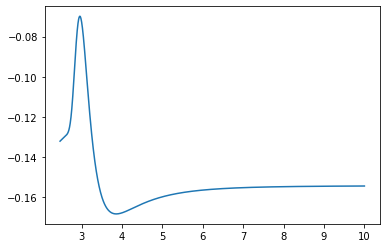

In [707]:
plt.plot(CC_X[::2][500:], total_potential6)

In [708]:
total_potential6[-1]

-0.15454738229390377

In [709]:
offset6 = (CC_energies_dist_pow6[-1]*len(CC_energies_dist_pow6)
                    + CH_energies_dist_pow6[-1]*len(CH_energies_dist_pow6[400:])
                    + HH_energies_dist_pow6[-1]*len(HH_energies_dist_pow6[500:])) /(len(CC_energies_dist_pow6)+len(CH_energies_dist_pow6[400:])+len(HH_energies_dist_pow6[500:]))
offset6

-0.15454738229390377

In [30]:
kernel_6_12 = kernel_matrix_dist_pow6 + kernel_matrix_dist_pow12
diags612 = np.diag(kernel_6_12)
norm_kernel6_12 = kernel_6_12 / np.sqrt(np.outer(diags612, diags612))

In [605]:
opt_alpha6_12 = new_kernel_regression(energies, norm_kernel6_12, 0.0523)
opt_energies6_12 = energy_fit(norm_kernel6_12, opt_alpha6_12)

/local/home/local/miniconda3/envs/librascal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [606]:
np.linalg.cond(norm_kernel6_12 + np.eye(len(norm_kernel6_12[0])))

2067.219115393831

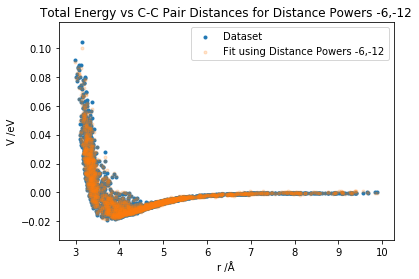

In [607]:
plt.scatter(X.T[2][X.T[2] != 0][::2], energies, marker = ".", label="Dataset")
plt.scatter(X.T[2][X.T[2] != 0][::2], opt_energies6_12,marker=".", label="Fit using Distance Powers -6,-12", alpha=0.2)
plt.xlabel("r /Å")
plt.ylabel("V /eV")
plt.title("Total Energy vs C-C Pair Distances for Distance Powers -6,-12")
plt.legend()
plt.show()

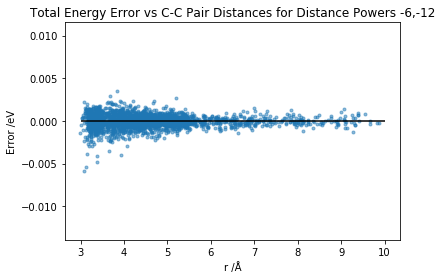

In [608]:
plt.scatter(X.T[2][X.T[2] != 0][::2], opt_energies6_12-energies,marker=".", alpha=0.5)
plt.hlines(0, 3,10)
plt.xlabel("r /Å")
plt.ylabel("Error /eV")
plt.title("Total Energy Error vs C-C Pair Distances for Distance Powers -6,-12")
plt.show()

In [609]:
np.sqrt(np.mean((opt_energies6_12-energies)**2))/2

0.0003893189578548517

In [610]:
CC_k_6_12 = CC_k_dist_pow6 + CC_k_dist_pow12
norm_CC_k_6_12 = CC_k_6_12 / (2*np.sqrt(diags612))
CH_k_6_12 = CH_k_dist_pow6 + CH_k_dist_pow12
norm_CH_k_6_12 = CH_k_6_12 / (2*np.sqrt(diags612))
HH_k_6_12 = HH_k_dist_pow6 + HH_k_dist_pow12
norm_HH_k_6_12 = HH_k_6_12 / (2*np.sqrt(diags612))
CC_energies_6_12 = energy_fit(norm_CC_k_6_12, opt_alpha6_12)
CH_energies_6_12 = energy_fit(norm_CH_k_6_12, opt_alpha6_12)
HH_energies_6_12 = energy_fit(norm_HH_k_6_12, opt_alpha6_12)

In [611]:
np.linalg.cond(norm_CC_k_6_12 + np.eye(len(norm_CC_k_6_12[0])))

572.2569082048196

In [612]:
np.linalg.cond(norm_CH_k_6_12 + np.eye(len(norm_CH_k_6_12[0])))

20685.89736526487

In [613]:
np.linalg.cond(norm_HH_k_6_12 + np.eye(len(norm_HH_k_6_12[0])))

33608.55869000289

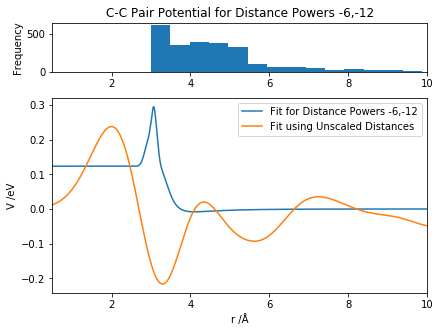

In [734]:
fig = plt.figure(figsize=(6,4.5), constrained_layout=True)

heights = [1, 4]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

axs=[]
axs0 = fig.add_subplot(spec[0,0])
axs1 = fig.add_subplot(spec[1,0])
axs.append(axs0)
axs.append(axs1)

axs[0].hist(CC_dist, bins = CCn)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0.5,10)
axs[0].set_title("C-C Pair Potential for Distance Powers -6,-12")

axs[1].plot(CC_X[::2], CC_energies_6_12-CC_energies_6_12[-1],marker="", linestyle="-", label="Fit for Distance Powers -6,-12")
axs[1].plot(CC_X[::2], CC_energies,marker="", linestyle="-", label="Fit using Unscaled Distances")
axs[1].set_ylabel("V /eV")
axs[1].set_xlim(0.5,10)

plt.xlabel("r /Å")
plt.legend()
plt.show()

In [723]:
np.min(CC_energies_6_12-CC_energies_6_12[-1])

-0.008170432316563003

In [737]:
np.min(CC_energies_6_12)

-0.13138997453809045

In [738]:
list(CC_energies_6_12).index(-0.13138997453809045)

917

In [739]:
CC_X[::2][917]

array([4.10426148])

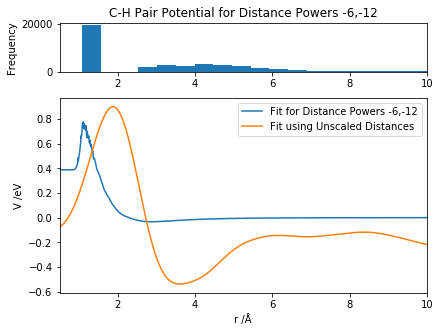

In [735]:
fig = plt.figure(figsize=(6,4.5), constrained_layout=True)

heights = [1, 4]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

axs=[]
axs0 = fig.add_subplot(spec[0,0])
axs1 = fig.add_subplot(spec[1,0])
axs.append(axs0)
axs.append(axs1)

axs[0].hist(CH_dist, bins = CHn)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0.5,10)
axs[0].set_title("C-H Pair Potential for Distance Powers -6,-12")

axs[1].plot(CH_X[::2], CH_energies_6_12-CH_energies_6_12[-1],marker="", linestyle="-", label="Fit for Distance Powers -6,-12")
axs[1].plot(CH_X[::2], CH_energies,marker="", linestyle="-", label="Fit using Unscaled Distances")
axs[1].set_ylabel("V /eV")
axs[1].set_xlim(0.5,10)

plt.xlabel("r /Å")
plt.legend()
plt.show()

In [725]:
np.min(CH_energies_6_12-CH_energies_6_12[-1])

-0.03305913139369343

In [743]:
np.min(CH_energies)

-0.5376373490812698

In [744]:
list(CH_energies).index(-0.5376373490812698)

792

In [745]:
CC_X[::2][792]

array([3.61294994])

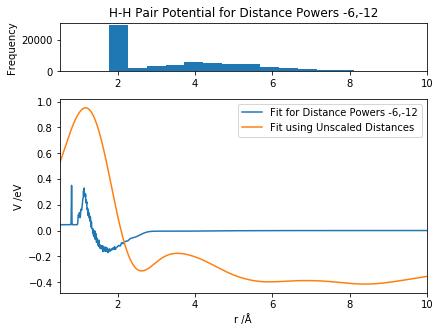

In [736]:
fig = plt.figure(figsize=(6,4.5), constrained_layout=True)

heights = [1, 4]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

axs=[]
axs0 = fig.add_subplot(spec[0,0])
axs1 = fig.add_subplot(spec[1,0])
axs.append(axs0)
axs.append(axs1)

axs[0].hist(HH_dist, bins = HHn)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0.5,10)
axs[0].set_title("H-H Pair Potential for Distance Powers -6,-12")

axs[1].plot(HH_X[::2], HH_energies_6_12-HH_energies_6_12[-1],marker="", linestyle="-", label="Fit for Distance Powers -6,-12")
axs[1].plot(HH_X[::2], HH_energies,marker="", linestyle="-", label="Fit using Unscaled Distances")
axs[1].set_ylabel("V /eV")
axs[1].set_xlim(0.5,10)

plt.xlabel("r /Å")
plt.legend()
plt.show()

In [727]:
np.min(HH_energies_6_12-HH_energies_6_12[-1])

-0.17079973076732027

In [694]:
np.min(HH_energies)

-0.41518126571664254

In [695]:
list(HH_energies).index(-0.41518126571664254)

2010

In [693]:
CC_X[::2][319]

array([1.75382706])

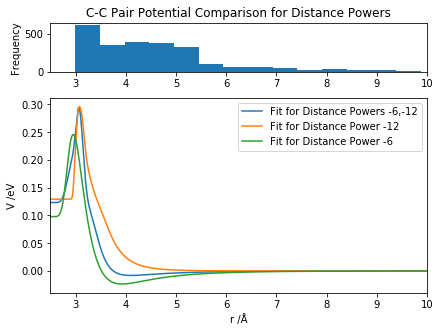

In [728]:
fig = plt.figure(figsize=(6,4.5), constrained_layout=True)

heights = [1, 4]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

axs=[]
axs0 = fig.add_subplot(spec[0,0])
axs1 = fig.add_subplot(spec[1,0])
axs.append(axs0)
axs.append(axs1)

axs[0].hist(CC_dist, bins = CCn)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(2.5,10)
axs[0].set_title("C-C Pair Potential Comparison for Distance Powers")

axs[1].plot(CC_X[::2], CC_energies_6_12-CC_energies_6_12[-1],marker="", linestyle="-", label="Fit for Distance Powers -6,-12")
axs[1].plot(CC_X[::2], CC_energies_dist_pow12-CC_energies_dist_pow12[-1],marker="", linestyle="-", label="Fit for Distance Power -12")
axs[1].plot(CC_X[::2], CC_energies_dist_pow6-CC_energies_dist_pow6[-1],marker="", linestyle="-", label="Fit for Distance Power -6")
axs[1].set_ylabel("V /eV")
axs[1].set_xlim(2.5,10)

plt.xlabel("r /Å")
plt.legend()
plt.show()

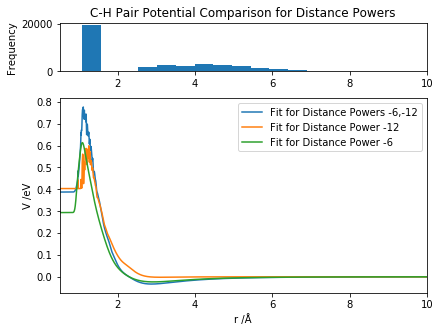

In [729]:
fig = plt.figure(figsize=(6,4.5), constrained_layout=True)

heights = [1, 4]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

axs=[]
axs0 = fig.add_subplot(spec[0,0])
axs1 = fig.add_subplot(spec[1,0])
axs.append(axs0)
axs.append(axs1)

axs[0].hist(CH_dist, bins = CHn)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0.5,10)
axs[0].set_title("C-H Pair Potential Comparison for Distance Powers")

axs[1].plot(CH_X[::2], CH_energies_6_12-CH_energies_6_12[-1],marker="", linestyle="-", label="Fit for Distance Powers -6,-12")
axs[1].plot(CH_X[::2], CH_energies_dist_pow12-CH_energies_dist_pow12[-1],marker="", linestyle="-", label="Fit for Distance Power -12")
axs[1].plot(CH_X[::2], CH_energies_dist_pow6-CH_energies_dist_pow6[-1],marker="", linestyle="-", label="Fit for Distance Power -6")
axs[1].set_ylabel("V /eV")
axs[1].set_xlim(0.5,10)

plt.xlabel("r /Å")
plt.legend()
plt.show()

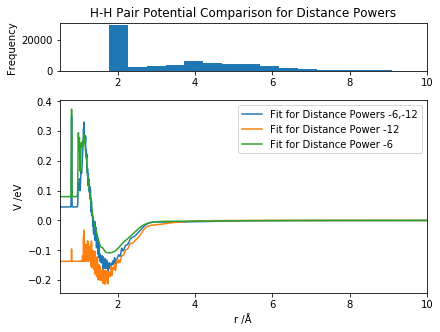

In [730]:
fig = plt.figure(figsize=(6,4.5), constrained_layout=True)

heights = [1, 4]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

axs=[]
axs0 = fig.add_subplot(spec[0,0])
axs1 = fig.add_subplot(spec[1,0])
axs.append(axs0)
axs.append(axs1)

axs[0].hist(HH_dist, bins = HHn)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0.5,10)
axs[0].set_title("H-H Pair Potential Comparison for Distance Powers")

axs[1].plot(HH_X[::2], HH_energies_6_12-HH_energies_6_12[-1],marker="", linestyle="-", label="Fit for Distance Powers -6,-12")
axs[1].plot(HH_X[::2], HH_energies_dist_pow12-HH_energies_dist_pow12[-1],marker="", linestyle="-", label="Fit for Distance Power -12")
axs[1].plot(HH_X[::2], HH_energies_dist_pow6-HH_energies_dist_pow6[-1],marker="", linestyle="-", label="Fit for Distance Power -6")
axs[1].set_ylabel("V /eV")
axs[1].set_xlim(0.5,10)

plt.xlabel("r /Å")
plt.legend()
plt.show()

In [589]:
np.savez("6-12_kernels", kernel_6_12=kernel_6_12, CC_kernel_6_12= CC_k_6_12, CH_kernel_6_12=CH_k_6_12,
HH_kernel_6_12 = HH_k_6_12)

In [590]:
kernels_6_12 = np.load("6-12_kernels.npz")

In [591]:
kernels_6_12["kernel_6_12"]

array([[3275.05811007, 3434.67312201, 3032.33322897, ..., 2021.6929701 ,
        2100.90430575, 2356.03970942],
       [3434.67312201, 3837.30292304, 3304.39089817, ..., 2070.44212519,
        2226.9411697 , 2568.59886575],
       [3032.33322897, 3304.39089817, 3619.20835696, ..., 2214.99567651,
        2598.37626721, 2415.04979515],
       ...,
       [2021.6929701 , 2070.44212519, 2214.99567651, ..., 2036.51951262,
        1787.0438359 , 1717.92234402],
       [2100.90430575, 2226.9411697 , 2598.37626721, ..., 1787.0438359 ,
        2365.66095892, 2078.74529696],
       [2356.03970942, 2568.59886575, 2415.04979515, ..., 1717.92234402,
        2078.74529696, 2423.46867719]])

In [592]:
np.savez("2:1_kernels", kernel_2_1=kernel_2_1, CC_kernel_2_1=CC_k_2_1, CH_kernel_2_1=CH_k_2_1, HH_kernel_2_1=HH_k_2_1)

In [593]:
np.savez("12_kernels", kernel_12=kernel_matrix_dist_pow12, CC_kernel_12=CC_k_dist_pow12, CH_kernel_12=CH_k_dist_pow12,
         HH_kernel_12=HH_k_dist_pow12)

In [594]:
np.savez("6_kernels", kernel_6=kernel_matrix_dist_pow6, CC_kernel_6=CC_k_dist_pow6, CH_kernel_6=CH_k_dist_pow6,
         HH_kernel_6=HH_k_dist_pow6)

In [595]:
np.savez("test_kernels", CC_kernel=pp_kernel, CH_kernel=CH_kernel, HH_kernel=HH_kernel)

In [596]:
np.savez("regular_NN_kernels", theta_1_kernel=kernel_matrix, theta_2_kernel=kernel_matrix2, theta_half_kernel=kernel_matrix_half)

In [621]:
np.save("best_fitted_energies", opt_energies6_12)

In [622]:
np.save("best_CC_pair_potential", CC_energies_6_12)

In [623]:
np.save("best_CH_pair_potential", CH_energies_6_12)

In [624]:
np.save("best_HH_pair_potential", HH_energies_6_12)